In [154]:
import pandas as pd

In [155]:
import numpy as np

In [156]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [157]:
path = "/content/drive/My Drive/Hackhathon 2020 Shared Drive/Dataset/SG_car_cleaned.csv"

In [158]:
import requests
# download dataset from google drive
def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

In [306]:
data = pd.read_csv(path)

In [307]:
data = data.drop(['Unnamed: 0','Unnamed: 0.1','trj_id', 'osname', 'pingtimestamp', 'timestamp', 'latitude', 'longitude', 'speed', 'bearing', 'accuracy', 'pickup_time', 'dropoff_time'], axis=1)

In [308]:
data

,travel_time,latitude_origin,longitude_origin,latitude_destination,longitude_destination,hour_of_day,day_of_week,is_weekend,is_weekday,is_wee_hours,is_rush_hours_morning,is_rush_hours_evening,sin_hour_of_day,cos_hour_of_day,sin_day_of_week,cos_day_of_week,haversine_km,haversine_m,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1
0,1520.0,1.270377,103.857875,1.446609,103.806354,2,1,0,1,0,0,0,5.000000e-01,0.866025,0.781831,0.623490,20.403093,12.677028,-0.025486,-0.076384,0.041837,0.094437
1,1158.0,1.282591,103.851082,1.332855,103.977278,8,4,0,1,0,0,0,8.660254e-01,-0.500000,-0.433884,-0.900969,15.091547,9.376812,-0.017611,-0.064838,-0.138717,-0.003314
2,1366.0,1.355363,103.863157,1.343218,103.858504,10,5,1,0,0,0,1,5.000000e-01,-0.866025,-0.974928,-0.222521,1.445192,0.897939,-0.023023,0.008731,-0.019494,-0.003787
3,1328.0,1.340301,103.775742,1.303071,103.900220,1,5,1,0,0,0,0,2.588190e-01,0.965926,-0.974928,-0.222521,14.434456,8.968542,0.062661,-0.014213,-0.064685,-0.039977
4,1210.0,1.333936,103.953225,1.309601,103.833983,7,3,0,1,0,0,0,9.659258e-01,-0.258819,0.433884,-0.900969,13.520439,8.400637,-0.114666,-0.004423,0.001871,-0.039493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27537,1112.0,1.396872,103.747718,1.319548,103.843496,22,0,0,1,0,0,0,-5.000000e-01,0.866025,0.000000,1.000000,13.676692,8.497722,0.095710,0.039577,-0.006699,-0.028723
27538,983.0,1.396533,103.747537,1.322236,103.841737,22,1,0,1,0,0,0,-5.000000e-01,0.866025,0.781831,0.623490,13.329784,8.282178,0.095859,0.039224,-0.004703,-0.026205
27539,1382.0,1.301317,103.899443,1.410657,103.778843,1,6,1,0,0,0,0,2.588190e-01,0.965926,-0.781831,0.623490,18.086938,11.237934,-0.064071,-0.041795,0.065966,0.056133
27540,1212.0,1.298612,103.853801,1.341311,103.981728,11,2,0,1,0,0,1,2.588190e-01,-0.965926,0.974928,-0.222521,14.983214,9.309501,-0.018864,-0.048636,-0.142380,0.005511


#Modelling

In [309]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
data = data.sample(frac=1).reset_index(drop=True)
train, test = train_test_split(data, test_size=0.3, train_size = 0.7, random_state = 11)
validate, test = train_test_split(test, test_size = 0.3, train_size = 0.7, random_state = 11)
print(len(train))
print(len(validate))
print(len(test))

19279
5784
2479


In [ ]:
random state 10, XGB= 230.98, LGB = 237.94

In [115]:
from sklearn import preprocessing

In [310]:
train_scaled = preprocessing.scale(train[train.columns.difference(['travel_time'])])
X_train = train_scaled
Y_train = train["travel_time"]
val_scaled = preprocessing.scale(validate[validate.columns.difference(['travel_time'])])
X_val = val_scaled
Y_val = validate["travel_time"]
test_scaled = preprocessing.scale(test[test.columns.difference(['travel_time'])])
X_test = test_scaled
Y_test = test["travel_time"]

In [17]:
import timeit
"""start = timeit.default_timer()
main()
end = timeit.default_timer()
print("Time taken in seconds:{}".format(end-start))"""

'start = timeit.default_timer()\nmain()\nend = timeit.default_timer()\nprint("Time taken in seconds:{}".format(end-start))'

#XGBoost

In [311]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_val, label=Y_val)
dtest = xgb.DMatrix(X_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [312]:
start = timeit.default_timer()
evaluation_results = dict()
xgb_pars = {'min_child_weight': 10, 'eta': 0.005 ,'colsample_bytree': 0.9, 
            'max_depth': 10,
'subsample': 0.1, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, dtrain, 2000, watchlist, early_stopping_rounds=40,
      maximize=False, verbose_eval=1, evals_result = evaluation_results)
end = timeit.default_timer()
print("Time taken in seconds:{}".format(end-start))
print('Modeling RMSE %.5f' % model.best_score)

[0]	train-rmse:1251.18	valid-rmse:1246.17
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 40 rounds.
[1]	train-rmse:1245.2	valid-rmse:1240.18
[2]	train-rmse:1239.22	valid-rmse:1234.21
[3]	train-rmse:1233.25	valid-rmse:1228.25
[4]	train-rmse:1227.33	valid-rmse:1222.34
[5]	train-rmse:1221.45	valid-rmse:1216.46
[6]	train-rmse:1215.57	valid-rmse:1210.6
[7]	train-rmse:1209.75	valid-rmse:1204.79
[8]	train-rmse:1203.99	valid-rmse:1199.04
[9]	train-rmse:1198.26	valid-rmse:1193.32
[10]	train-rmse:1192.5	valid-rmse:1187.56
[11]	train-rmse:1186.75	valid-rmse:1181.82
[12]	train-rmse:1181.07	valid-rmse:1176.13
[13]	train-rmse:1175.39	valid-rmse:1170.46
[14]	train-rmse:1169.78	valid-rmse:1164.86
[15]	train-rmse:1164.15	valid-rmse:1159.24
[16]	train-rmse:1158.58	valid-rmse:1153.68
[17]	train-rmse:1153.05	valid-rmse:1148.14
[18]	train-rmse:1147.49	valid-rmse:1142.59
[19]	train-rmse:1142.04	valid-rmse:1137.15
[20]	tra

In [313]:
ypred1 = model.predict(dtest)
mse = mean_squared_error(Y_test,ypred1)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 197.55


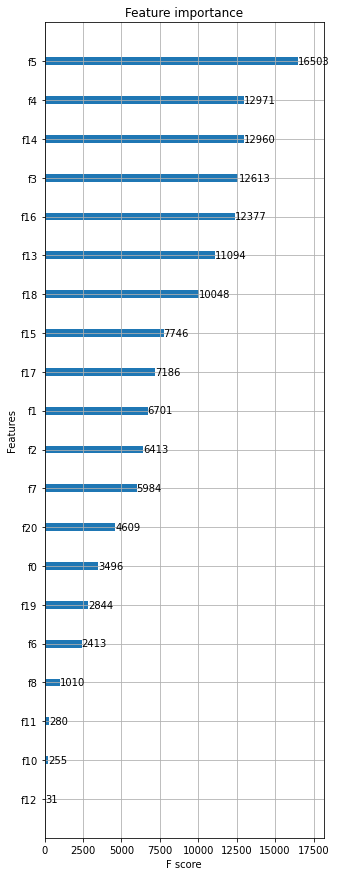

In [314]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5, 15)
xgb.plot_importance(booster=model)

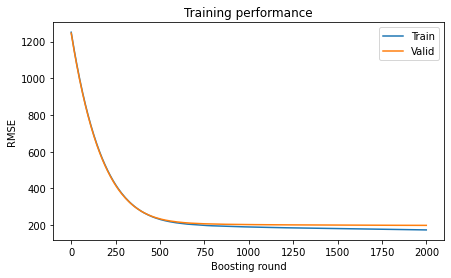

In [315]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=[7, 4])

# Plot the log loss during training
axs.plot(evaluation_results['train']['rmse'], label='Train')
axs.plot(evaluation_results['valid']['rmse'], label='Valid')
axs.set_ylabel('RMSE')
axs.set_xlabel('Boosting round')
axs.set_title('Training performance')
axs.legend()

plt.show()

In [ ]:
import joblib
# save model
joblib.dump(model, '/content/drive/My Drive/Hackhathon 2020 Shared Drive/model/xgbIvan.pkl')

In [126]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

#LightGBM

In [193]:
import lightgbm as lgb

In [316]:
d_train = lgb.Dataset(X_train, label=Y_train)
d_valid = lgb.Dataset(X_val, label=Y_val)

In [317]:
start = timeit.default_timer()

evaluation_results = {}
params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'rmse'
params['sub_feature'] = 0.9
params['num_leaves'] = 2
params['min_data'] = 20
params['max_depth'] = 10
params['max_bin'] = 20
params['bagging_fraction']= 0.9
clf = lgb.train(params, d_train, valid_sets=[d_train, d_valid],
                num_boost_round = 50000,valid_names=['Train', 'Valid'],
                evals_result = evaluation_results, early_stopping_rounds = 40)
end = timeit.default_timer()
print("Time taken in seconds:{}".format(end-start))

Output streaming akan dipotong hingga 5000 baris terakhir.
[9598]	Train's rmse: 223.426	Valid's rmse: 223.505
[9599]	Train's rmse: 223.426	Valid's rmse: 223.505
[9600]	Train's rmse: 223.426	Valid's rmse: 223.505
[9601]	Train's rmse: 223.425	Valid's rmse: 223.505
[9602]	Train's rmse: 223.425	Valid's rmse: 223.505
[9603]	Train's rmse: 223.425	Valid's rmse: 223.504
[9604]	Train's rmse: 223.425	Valid's rmse: 223.505
[9605]	Train's rmse: 223.425	Valid's rmse: 223.505
[9606]	Train's rmse: 223.424	Valid's rmse: 223.505
[9607]	Train's rmse: 223.424	Valid's rmse: 223.504
[9608]	Train's rmse: 223.424	Valid's rmse: 223.504
[9609]	Train's rmse: 223.424	Valid's rmse: 223.504
[9610]	Train's rmse: 223.424	Valid's rmse: 223.504
[9611]	Train's rmse: 223.424	Valid's rmse: 223.503
[9612]	Train's rmse: 223.423	Valid's rmse: 223.503
[9613]	Train's rmse: 223.423	Valid's rmse: 223.503
[9614]	Train's rmse: 223.423	Valid's rmse: 223.502
[9615]	Train's rmse: 223.423	Valid's rmse: 223.502
[9616]	Train's rmse: 22

In [318]:
y_pred2 = clf.predict(X_test)
mse = mean_squared_error(Y_test,y_pred2)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 220.42


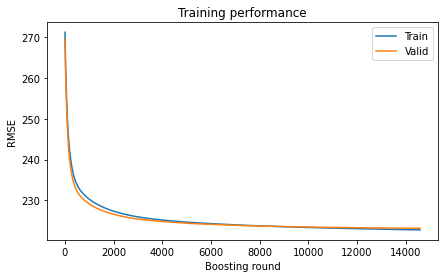

In [319]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=[7, 4])

# Plot the log loss during training
axs.plot(evaluation_results['Train']['rmse'], label='Train')
axs.plot(evaluation_results['Valid']['rmse'], label='Valid')
axs.set_ylabel('RMSE')
axs.set_xlabel('Boosting round')
axs.set_title('Training performance')
axs.legend()

plt.show()

In [304]:
import joblib
# save model
joblib.dump(clf, '/content/drive/My Drive/Hackhathon 2020 Shared Drive/model/lgbIvan.pkl')

['/content/drive/My Drive/Hackhathon 2020 Shared Drive/model/lgbIvan.pkl']

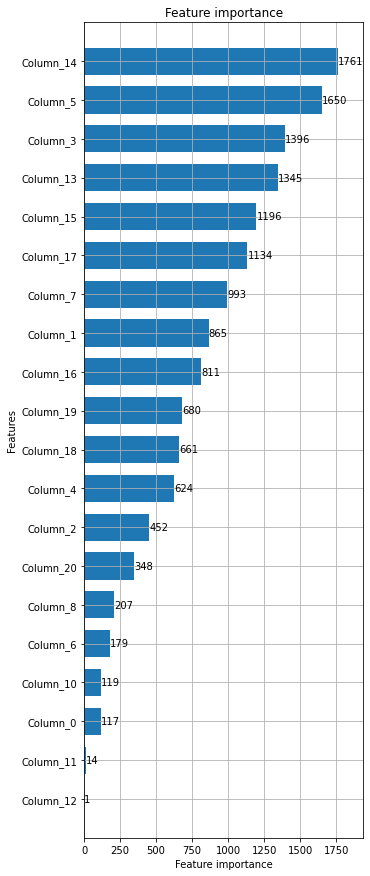

In [320]:
lgb.plot_importance(clf, max_num_features=51, height=0.7, figsize=(5,15))

#Catboost

In [128]:
pip install catboost==0.7.2

     |████████████████████████████████| 33.4MB 106kB/s 


In [321]:
from catboost import CatBoostRegressor

In [322]:
mode = CatBoostRegressor(iterations=2800,
                          learning_rate=0.05,
                          task_type = "CPU",
                          depth=5,
                         od_type = 'Iter',
                         od_wait=40)
# Fit model
mode.fit(X_train, Y_train,eval_set=(X_val, Y_val))


0:	learn: 1197.8882670	test: 1192.8881846	best: 1192.8881846 (0)	total: 18.5ms	remaining: 51.9s
1:	learn: 1140.8475620	test: 1135.8230955	best: 1135.8230955 (1)	total: 35.4ms	remaining: 49.5s
2:	learn: 1087.0610687	test: 1082.0762904	best: 1082.0762904 (2)	total: 53.2ms	remaining: 49.6s
3:	learn: 1036.0755896	test: 1031.0705198	best: 1031.0705198 (3)	total: 70.7ms	remaining: 49.4s
4:	learn: 987.4142253	test: 982.4044854	best: 982.4044854 (4)	total: 88.2ms	remaining: 49.3s
5:	learn: 941.1926258	test: 936.2221934	best: 936.2221934 (5)	total: 105ms	remaining: 49.1s
6:	learn: 897.3702581	test: 892.4677833	best: 892.4677833 (6)	total: 124ms	remaining: 49.3s
7:	learn: 855.9738244	test: 851.1097733	best: 851.1097733 (7)	total: 145ms	remaining: 50.7s
8:	learn: 817.1212177	test: 812.2598914	best: 812.2598914 (8)	total: 162ms	remaining: 50.4s
9:	learn: 780.2521535	test: 775.3985417	best: 775.3985417 (9)	total: 187ms	remaining: 52.2s
10:	learn: 745.2788238	test: 740.4037490	best: 740.4037490 (10)

In [323]:
# Get predictions
y_pred3 = mode.predict(X_test)
mse = mean_squared_error(Y_test,y_pred3)
print("RMSE: %.2f" % np.sqrt(mse))

RMSE: 193.48
